In [18]:
from snntorch import functional as SF
import torch.nn as nn
from utils import save_history_plot
import torch
from utils import get_device
from torch.utils.data import DataLoader
from tonic import datasets, transforms
import torch.nn as nn
import snntorch as snn
import torch

In [19]:
time_steps = 100
num_inputs = 700
num_hidden = 1000
num_outputs = 20
dtype = torch.float
batch_size = 32

max_time = 1.4
beta = 0.99
device = get_device()

In [20]:
class SingleHiddenLayer1000NeuronsNet(nn.Module):
    def __init__(self, num_inputs, num_outputs, beta, time_steps):
        super().__init__()

        self.time_steps = time_steps

        # Initialize layers
        self.fc1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

    def forward(self, x):

        # Initialize hidden states at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        spk1_rec = []
        mem1_rec = []

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        for step in range(self.time_steps):
            cur1 = self.fc1(x[step])
            spk1, mem1 = self.lif1(cur1, mem1)
            spk1_rec.append(spk1)
            mem1_rec.append(mem1)

            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk1_rec, dim=0), torch.stack(mem1_rec, dim=0), torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [ ]:
untrained_model = SingleHiddenLayer1000NeuronsNet(num_inputs=num_inputs, num_outputs=num_outputs, beta=beta, time_steps=time_steps).to(device)

trained_model = SingleHiddenLayer1000NeuronsNet(num_inputs=num_inputs, num_outputs=num_outputs, beta=beta, time_steps=time_steps)
trained_model.load_state_dict(torch.load('./models/30_epochs_simplified.pth'))

<All keys matched successfully>

In [22]:
frame_transform = transforms.ToFrame(
    sensor_size=datasets.SHD.sensor_size,  
    n_time_bins=time_steps
)

test_data = datasets.SHD("./data", transform=frame_transform, train=False)

test_data_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [23]:
data, target = list(test_data_loader)[0]
data = data.to_dense().to(torch.float32).squeeze().permute(1, 0, 2).to(device)

In [ ]:
selection_index = 0

x_selected = data[:, selection_index, :]
y_selected = target[selection_index]

hidden_spk_rec_untrained, _, output_spk_rec_untrained, _ = untrained_model(data)

x_hidden_untrained_selected = hidden_spk_rec_untrained[:, selection_index, :]
x_output_untrained_selected = output_spk_rec_untrained[:, selection_index, :]

hidden_spk_rec_trained, _, output_spk_rec_trained, _ = trained_model(data)

x_hidden_trained_selected = hidden_spk_rec_trained[:, selection_index, :]
x_output_trained_selected = output_spk_rec_trained[:, selection_index, :]

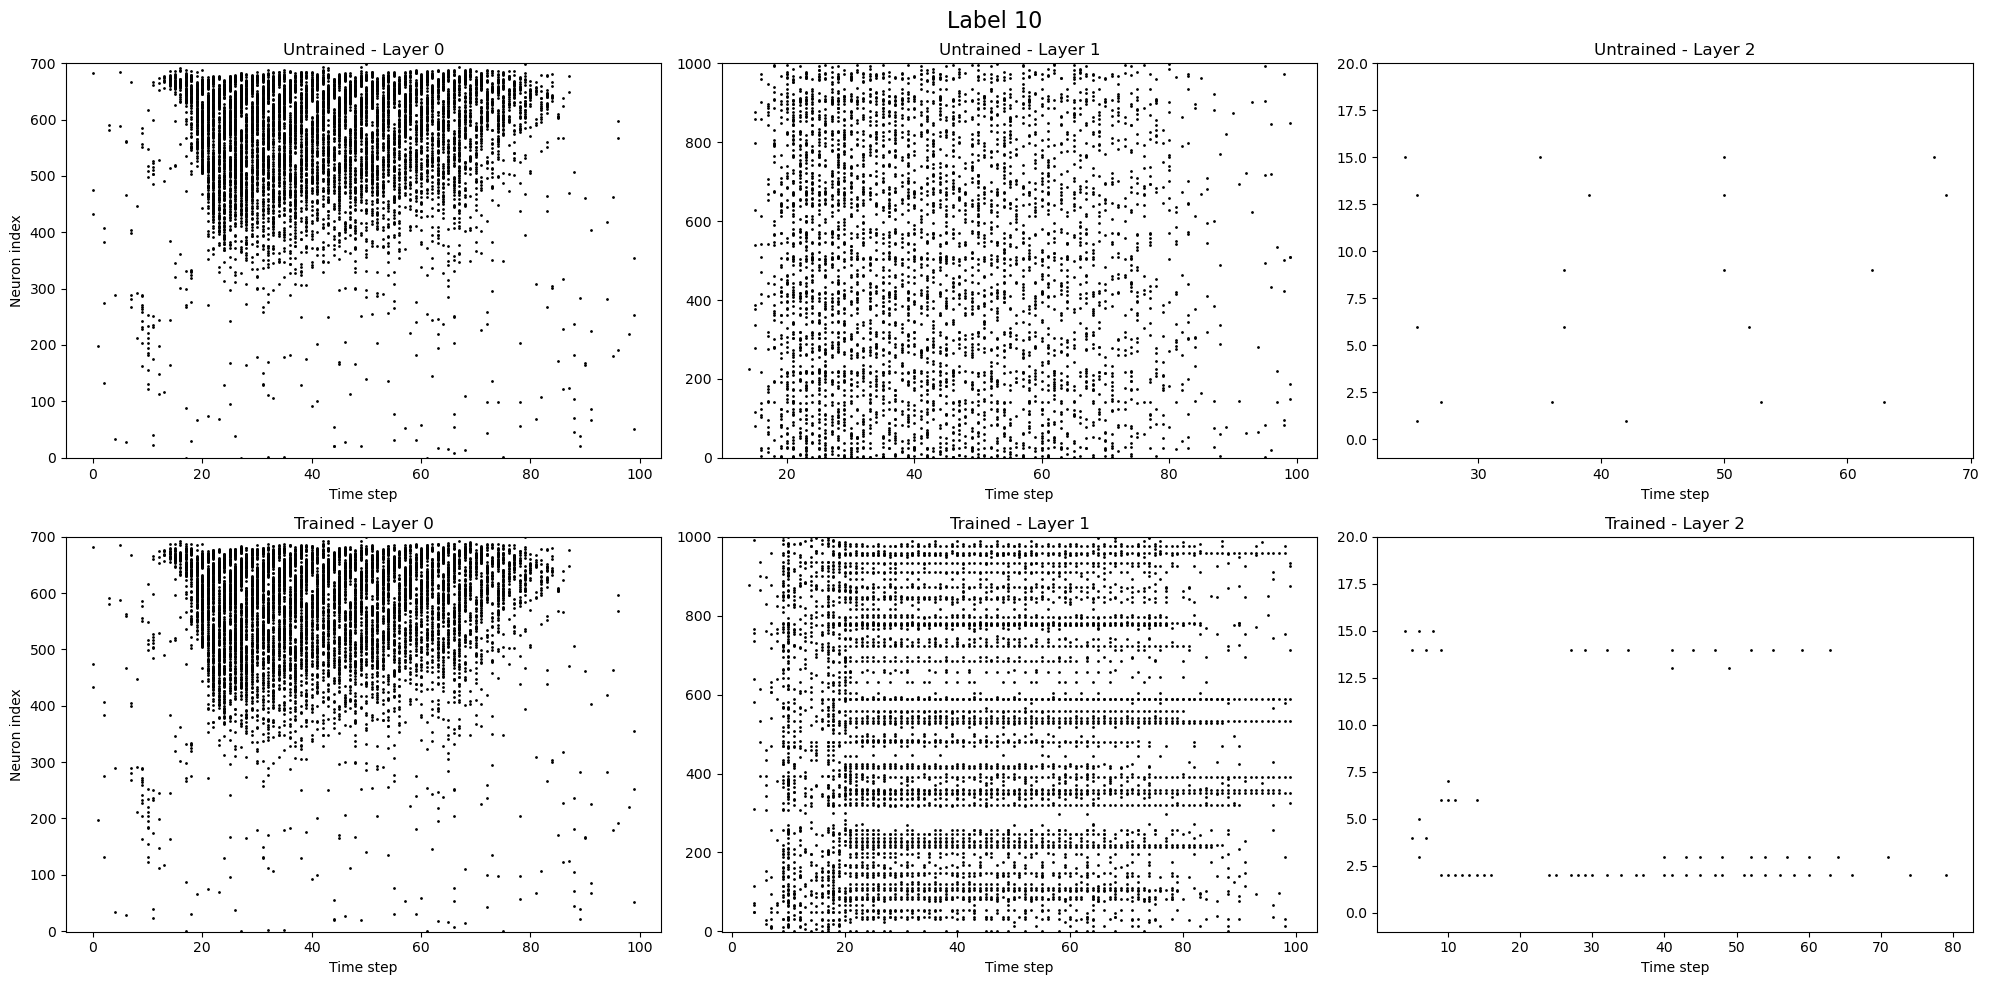

In [34]:
import matplotlib.pyplot as plt
import numpy as np

spike_matrices_untrained = [x_selected, x_hidden_untrained_selected.detach(), x_output_untrained_selected.detach()]
spike_matrices_trained = [x_selected, x_hidden_trained_selected.detach(), x_output_trained_selected.detach()]

# 2 rows (untrained on top, trained on bottom), 3 columns
fig, axes = plt.subplots(2, 3, figsize=(20, 10))

fig.suptitle(f"Label {y_selected}", fontsize=16)

for index in range(3):
    # Untrained plot (top row)
    spike_matrix_np = spike_matrices_untrained[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax_untrained = axes[0, index]
    ax_untrained.scatter(times, neurons, s=1, color='black')
    ax_untrained.set_title(f"Untrained - Layer {index}")
    ax_untrained.set_xlabel("Time step")
    ax_untrained.set_ylim(-1, spike_matrix_np.shape[1])
    if index == 0:
        ax_untrained.set_ylabel("Neuron index")

    # Trained plot (bottom row)
    spike_matrix_np = spike_matrices_trained[index].numpy()
    times, neurons = np.where(spike_matrix_np == 1)
    ax_trained = axes[1, index]
    ax_trained.scatter(times, neurons, s=1, color='black')
    ax_trained.set_title(f"Trained - Layer {index}")
    ax_trained.set_xlabel("Time step")
    ax_trained.set_ylim(-1, spike_matrix_np.shape[1])
    if index == 0:
        ax_trained.set_ylabel("Neuron index")

plt.tight_layout()
plt.show()
